## Twitter Sentiment Prediction

### 1.1 Introduction

This project focuses on real-time Twitter sentiment analysis to classify tweets as positive, negative, or neutral using machine learning and deep learning models. The approach optimizes time and resources while providing actionable insights for businesses.

### 1.2 Metrics

1. Accuracy
2. Precision 
3. Recall 

### 1.3 Source 
The dataset is taken from Kaggle.

https://www.kaggle.com/c/tweet-sentiment-extraction/data

## Table of Contents

1. Reading the data
2. Countplot of the Sentiment
3. Positive Text WordCloud
4. Negative Text WordCloud
5. List of Stopwords
6. Dividing the data into training and Cross Validation Data
7. Function for Replacing Words
8. Preprocessing the Text
9. Tfidf Vectorizer
10. Neural Network Model for Prediction 
11. Count Vectorizer
12. Neural Network Model 
13. Plots of the Results 
14. Conclusion



In [162]:
%pip install wordcloud
%pip install pandas
%pip install seaborn
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install nltk
%pip install tqdm
%pip install --upgrade setuptools
%pip install torch torchvision torchaudio
%pip install transformers


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/203.0 MB 8.3 MB/s eta 0:00:25
   ---------------------------------------- 0.8/203.0 MB 12.5 MB/s eta 0:00:17
   ---------------------------------------- 1.4/203.0 MB 11.3 MB/s eta 0:00:18
   ---------------------------------------- 1.8/203.0 MB 11.6 MB/s eta 0:00:18
   ---------------------------------------- 2.1/203.0 MB 10.1 MB/s eta 0:00:20
   ---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

## 1. Reading the data 

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess dataset
data = pd.read_csv("train.csv")

data = data.dropna(subset=['text'])  # Remove rows with null 'text'
data['text'] = data['text'].str.lower()
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['sentiment'])

X = data['text']
y = data['label']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text using TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_val_tfidf = tfidf.transform(X_val).toarray()

Using device: cpu


In [3]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Prepare DataLoader
train_dataset = SentimentDataset(X_train_tfidf, y_train.values)
val_dataset = SentimentDataset(X_val_tfidf, y_val.values)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## 2. Countplot of the Sentiment 

As can be seen, there seems to be more neutral sentiment in the text compared to positive or negative tweets. That is true in real life as most of the tweets would be quite neutral without them being either too positive or too negative respectively. 

In [6]:
class SentimentModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(SentimentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Taking a look at the shape of the data, we see that there are about 27k data points that we are going to be working and applying our knowledge.

In [9]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in data_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1


param_grid = {
    'learning_rate': [0.0001],
    'hidden_dim': [64, 128, 256],
    'dropout_rate': [0.3, 0.5],
    'batch_size': [32, 64]
}

best_val_accuracy = 0
best_params = None
best_model = None

for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")
    model = SentimentModel(
        input_dim=X_train_tfidf.shape[1],
        hidden_dim=params['hidden_dim'],
        output_dim=len(label_encoder.classes_),
        dropout_rate=params['dropout_rate']
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    for epoch in range(10):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        for texts, labels in tqdm(train_loader):
            texts, labels = texts.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)

        val_accuracy, _, _, _ = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = params
            best_model = model

print(f"Best Parameters: {best_params}, Best Validation Accuracy: {best_val_accuracy:.4f}")


Training with parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'hidden_dim': 64, 'learning_rate': 0.0001}


100%|██████████| 687/687 [00:01<00:00, 366.58it/s]


Epoch 1, Loss: 1.0828, Train Accuracy: 0.4146, Validation Accuracy: 0.4443


100%|██████████| 687/687 [00:02<00:00, 292.18it/s]


Epoch 2, Loss: 1.0191, Train Accuracy: 0.5041, Validation Accuracy: 0.5590


100%|██████████| 687/687 [00:02<00:00, 262.87it/s]


Epoch 3, Loss: 0.9303, Train Accuracy: 0.6136, Validation Accuracy: 0.6197


100%|██████████| 687/687 [00:02<00:00, 251.32it/s]


Epoch 4, Loss: 0.8496, Train Accuracy: 0.6764, Validation Accuracy: 0.6497


100%|██████████| 687/687 [00:02<00:00, 240.15it/s]


Epoch 5, Loss: 0.7837, Train Accuracy: 0.7127, Validation Accuracy: 0.6639


100%|██████████| 687/687 [00:02<00:00, 241.94it/s]


Epoch 6, Loss: 0.7311, Train Accuracy: 0.7308, Validation Accuracy: 0.6723


100%|██████████| 687/687 [00:03<00:00, 225.97it/s]


Epoch 7, Loss: 0.6894, Train Accuracy: 0.7481, Validation Accuracy: 0.6754


100%|██████████| 687/687 [00:02<00:00, 258.60it/s]


Epoch 8, Loss: 0.6539, Train Accuracy: 0.7587, Validation Accuracy: 0.6805


100%|██████████| 687/687 [00:02<00:00, 251.84it/s]


Epoch 9, Loss: 0.6242, Train Accuracy: 0.7710, Validation Accuracy: 0.6858


100%|██████████| 687/687 [00:02<00:00, 259.19it/s]


Epoch 10, Loss: 0.5963, Train Accuracy: 0.7833, Validation Accuracy: 0.6881
Training with parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'hidden_dim': 128, 'learning_rate': 0.0001}


100%|██████████| 687/687 [00:02<00:00, 254.99it/s]


Epoch 1, Loss: 1.0720, Train Accuracy: 0.4204, Validation Accuracy: 0.4696


100%|██████████| 687/687 [00:03<00:00, 205.79it/s]


Epoch 2, Loss: 0.9699, Train Accuracy: 0.5487, Validation Accuracy: 0.6012


100%|██████████| 687/687 [00:03<00:00, 183.45it/s]


Epoch 3, Loss: 0.8512, Train Accuracy: 0.6646, Validation Accuracy: 0.6447


100%|██████████| 687/687 [00:04<00:00, 149.38it/s]


Epoch 4, Loss: 0.7591, Train Accuracy: 0.7133, Validation Accuracy: 0.6661


100%|██████████| 687/687 [00:03<00:00, 174.35it/s]


Epoch 5, Loss: 0.6919, Train Accuracy: 0.7453, Validation Accuracy: 0.6761


100%|██████████| 687/687 [00:03<00:00, 181.20it/s]


Epoch 6, Loss: 0.6413, Train Accuracy: 0.7650, Validation Accuracy: 0.6843


100%|██████████| 687/687 [00:03<00:00, 174.43it/s]


Epoch 7, Loss: 0.6009, Train Accuracy: 0.7784, Validation Accuracy: 0.6883


100%|██████████| 687/687 [00:03<00:00, 179.73it/s]


Epoch 8, Loss: 0.5672, Train Accuracy: 0.7943, Validation Accuracy: 0.6901


100%|██████████| 687/687 [00:03<00:00, 186.55it/s]


Epoch 9, Loss: 0.5401, Train Accuracy: 0.8032, Validation Accuracy: 0.6923


100%|██████████| 687/687 [00:03<00:00, 183.16it/s]


Epoch 10, Loss: 0.5161, Train Accuracy: 0.8110, Validation Accuracy: 0.6932
Training with parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'hidden_dim': 256, 'learning_rate': 0.0001}


100%|██████████| 687/687 [00:04<00:00, 144.24it/s]


Epoch 1, Loss: 1.0612, Train Accuracy: 0.4328, Validation Accuracy: 0.5329


100%|██████████| 687/687 [00:05<00:00, 119.92it/s]


Epoch 2, Loss: 0.9065, Train Accuracy: 0.6218, Validation Accuracy: 0.6521


100%|██████████| 687/687 [00:06<00:00, 109.95it/s]


Epoch 3, Loss: 0.7675, Train Accuracy: 0.7123, Validation Accuracy: 0.6690


100%|██████████| 687/687 [00:06<00:00, 108.33it/s]


Epoch 4, Loss: 0.6774, Train Accuracy: 0.7487, Validation Accuracy: 0.6774


100%|██████████| 687/687 [00:06<00:00, 105.77it/s]


Epoch 5, Loss: 0.6168, Train Accuracy: 0.7684, Validation Accuracy: 0.6901


100%|██████████| 687/687 [00:06<00:00, 103.60it/s]


Epoch 6, Loss: 0.5710, Train Accuracy: 0.7885, Validation Accuracy: 0.6900


100%|██████████| 687/687 [00:06<00:00, 107.52it/s]


Epoch 7, Loss: 0.5340, Train Accuracy: 0.8063, Validation Accuracy: 0.6918


100%|██████████| 687/687 [00:06<00:00, 108.43it/s]


Epoch 8, Loss: 0.5029, Train Accuracy: 0.8161, Validation Accuracy: 0.6923


100%|██████████| 687/687 [00:06<00:00, 107.59it/s]


Epoch 9, Loss: 0.4781, Train Accuracy: 0.8279, Validation Accuracy: 0.6914


100%|██████████| 687/687 [00:06<00:00, 105.86it/s]


Epoch 10, Loss: 0.4551, Train Accuracy: 0.8363, Validation Accuracy: 0.6901
Training with parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'hidden_dim': 64, 'learning_rate': 0.0001}


100%|██████████| 687/687 [00:01<00:00, 350.39it/s]


Epoch 1, Loss: 1.0868, Train Accuracy: 0.3960, Validation Accuracy: 0.4360


100%|██████████| 687/687 [00:02<00:00, 269.58it/s]


Epoch 2, Loss: 1.0346, Train Accuracy: 0.4789, Validation Accuracy: 0.5167


100%|██████████| 687/687 [00:02<00:00, 236.32it/s]


Epoch 3, Loss: 0.9628, Train Accuracy: 0.5715, Validation Accuracy: 0.5984


100%|██████████| 687/687 [00:02<00:00, 231.96it/s]


Epoch 4, Loss: 0.8914, Train Accuracy: 0.6416, Validation Accuracy: 0.6308


100%|██████████| 687/687 [00:03<00:00, 227.42it/s]


Epoch 5, Loss: 0.8313, Train Accuracy: 0.6816, Validation Accuracy: 0.6512


100%|██████████| 687/687 [00:03<00:00, 228.38it/s]


Epoch 6, Loss: 0.7817, Train Accuracy: 0.7053, Validation Accuracy: 0.6614


100%|██████████| 687/687 [00:03<00:00, 227.71it/s]


Epoch 7, Loss: 0.7397, Train Accuracy: 0.7206, Validation Accuracy: 0.6687


100%|██████████| 687/687 [00:02<00:00, 231.56it/s]


Epoch 8, Loss: 0.7079, Train Accuracy: 0.7336, Validation Accuracy: 0.6732


100%|██████████| 687/687 [00:03<00:00, 219.31it/s]


Epoch 9, Loss: 0.6776, Train Accuracy: 0.7456, Validation Accuracy: 0.6774


100%|██████████| 687/687 [00:03<00:00, 228.79it/s]


Epoch 10, Loss: 0.6501, Train Accuracy: 0.7580, Validation Accuracy: 0.6818
Training with parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'hidden_dim': 128, 'learning_rate': 0.0001}


100%|██████████| 687/687 [00:02<00:00, 241.46it/s]


Epoch 1, Loss: 1.0791, Train Accuracy: 0.4264, Validation Accuracy: 0.4629


100%|██████████| 687/687 [00:03<00:00, 181.11it/s]


Epoch 2, Loss: 0.9950, Train Accuracy: 0.5264, Validation Accuracy: 0.5742


100%|██████████| 687/687 [00:04<00:00, 165.34it/s]


Epoch 3, Loss: 0.8924, Train Accuracy: 0.6274, Validation Accuracy: 0.6386


100%|██████████| 687/687 [00:04<00:00, 155.64it/s]


Epoch 4, Loss: 0.8091, Train Accuracy: 0.6895, Validation Accuracy: 0.6576


100%|██████████| 687/687 [00:04<00:00, 160.99it/s]


Epoch 5, Loss: 0.7450, Train Accuracy: 0.7205, Validation Accuracy: 0.6689


100%|██████████| 687/687 [00:04<00:00, 157.42it/s]


Epoch 6, Loss: 0.6941, Train Accuracy: 0.7408, Validation Accuracy: 0.6774


100%|██████████| 687/687 [00:04<00:00, 162.30it/s]


Epoch 7, Loss: 0.6531, Train Accuracy: 0.7571, Validation Accuracy: 0.6849


100%|██████████| 687/687 [00:04<00:00, 159.56it/s]


Epoch 8, Loss: 0.6209, Train Accuracy: 0.7670, Validation Accuracy: 0.6874


100%|██████████| 687/687 [00:04<00:00, 156.11it/s]


Epoch 9, Loss: 0.5929, Train Accuracy: 0.7784, Validation Accuracy: 0.6940


100%|██████████| 687/687 [00:04<00:00, 147.60it/s]


Epoch 10, Loss: 0.5667, Train Accuracy: 0.7922, Validation Accuracy: 0.6934
Training with parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'hidden_dim': 256, 'learning_rate': 0.0001}


100%|██████████| 687/687 [00:04<00:00, 146.98it/s]


Epoch 1, Loss: 1.0676, Train Accuracy: 0.4299, Validation Accuracy: 0.5022


100%|██████████| 687/687 [00:06<00:00, 113.14it/s]


Epoch 2, Loss: 0.9410, Train Accuracy: 0.5830, Validation Accuracy: 0.6223


100%|██████████| 687/687 [00:07<00:00, 92.24it/s]


Epoch 3, Loss: 0.8112, Train Accuracy: 0.6831, Validation Accuracy: 0.6601


100%|██████████| 687/687 [00:07<00:00, 91.82it/s]


Epoch 4, Loss: 0.7215, Train Accuracy: 0.7280, Validation Accuracy: 0.6752


100%|██████████| 687/687 [00:07<00:00, 91.22it/s]


Epoch 5, Loss: 0.6593, Train Accuracy: 0.7528, Validation Accuracy: 0.6818


100%|██████████| 687/687 [00:07<00:00, 90.62it/s]


Epoch 6, Loss: 0.6127, Train Accuracy: 0.7710, Validation Accuracy: 0.6927


100%|██████████| 687/687 [00:07<00:00, 90.13it/s]


Epoch 7, Loss: 0.5753, Train Accuracy: 0.7843, Validation Accuracy: 0.6936


100%|██████████| 687/687 [00:07<00:00, 92.85it/s]


Epoch 8, Loss: 0.5448, Train Accuracy: 0.7985, Validation Accuracy: 0.6934


100%|██████████| 687/687 [00:07<00:00, 93.14it/s]


Epoch 9, Loss: 0.5189, Train Accuracy: 0.8094, Validation Accuracy: 0.6929


100%|██████████| 687/687 [00:07<00:00, 91.47it/s]


Epoch 10, Loss: 0.4961, Train Accuracy: 0.8175, Validation Accuracy: 0.6920
Training with parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'hidden_dim': 64, 'learning_rate': 0.0001}


100%|██████████| 344/344 [00:01<00:00, 323.81it/s]


Epoch 1, Loss: 1.0930, Train Accuracy: 0.3925, Validation Accuracy: 0.4794


100%|██████████| 344/344 [00:01<00:00, 339.10it/s]


Epoch 2, Loss: 1.0558, Train Accuracy: 0.4829, Validation Accuracy: 0.5066


100%|██████████| 344/344 [00:01<00:00, 305.66it/s]


Epoch 3, Loss: 1.0028, Train Accuracy: 0.5295, Validation Accuracy: 0.5593


100%|██████████| 344/344 [00:01<00:00, 298.57it/s]


Epoch 4, Loss: 0.9436, Train Accuracy: 0.5997, Validation Accuracy: 0.5953


100%|██████████| 344/344 [00:01<00:00, 301.66it/s]


Epoch 5, Loss: 0.8871, Train Accuracy: 0.6501, Validation Accuracy: 0.6225


100%|██████████| 344/344 [00:01<00:00, 286.08it/s]


Epoch 6, Loss: 0.8357, Train Accuracy: 0.6829, Validation Accuracy: 0.6401


100%|██████████| 344/344 [00:01<00:00, 299.97it/s]


Epoch 7, Loss: 0.7927, Train Accuracy: 0.7091, Validation Accuracy: 0.6561


100%|██████████| 344/344 [00:01<00:00, 292.95it/s]


Epoch 8, Loss: 0.7540, Train Accuracy: 0.7250, Validation Accuracy: 0.6628


100%|██████████| 344/344 [00:01<00:00, 295.57it/s]


Epoch 9, Loss: 0.7211, Train Accuracy: 0.7411, Validation Accuracy: 0.6698


100%|██████████| 344/344 [00:01<00:00, 291.19it/s]


Epoch 10, Loss: 0.6908, Train Accuracy: 0.7505, Validation Accuracy: 0.6725
Training with parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'hidden_dim': 128, 'learning_rate': 0.0001}


100%|██████████| 344/344 [00:01<00:00, 195.71it/s]
c:\Users\abhij\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Loss: 1.0876, Train Accuracy: 0.4034, Validation Accuracy: 0.4678


100%|██████████| 344/344 [00:01<00:00, 225.32it/s]


Epoch 2, Loss: 1.0320, Train Accuracy: 0.4965, Validation Accuracy: 0.5253


100%|██████████| 344/344 [00:01<00:00, 217.16it/s]


Epoch 3, Loss: 0.9510, Train Accuracy: 0.5826, Validation Accuracy: 0.5862


100%|██████████| 344/344 [00:01<00:00, 212.76it/s]


Epoch 4, Loss: 0.8705, Train Accuracy: 0.6449, Validation Accuracy: 0.6290


100%|██████████| 344/344 [00:01<00:00, 198.88it/s]


Epoch 5, Loss: 0.8016, Train Accuracy: 0.6981, Validation Accuracy: 0.6528


100%|██████████| 344/344 [00:01<00:00, 207.23it/s]


Epoch 6, Loss: 0.7455, Train Accuracy: 0.7258, Validation Accuracy: 0.6658


100%|██████████| 344/344 [00:01<00:00, 195.05it/s]


Epoch 7, Loss: 0.6981, Train Accuracy: 0.7478, Validation Accuracy: 0.6699


100%|██████████| 344/344 [00:01<00:00, 197.51it/s]


Epoch 8, Loss: 0.6588, Train Accuracy: 0.7630, Validation Accuracy: 0.6747


100%|██████████| 344/344 [00:01<00:00, 199.65it/s]


Epoch 9, Loss: 0.6264, Train Accuracy: 0.7725, Validation Accuracy: 0.6816


100%|██████████| 344/344 [00:01<00:00, 204.88it/s]


Epoch 10, Loss: 0.5969, Train Accuracy: 0.7853, Validation Accuracy: 0.6843
Training with parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'hidden_dim': 256, 'learning_rate': 0.0001}


100%|██████████| 344/344 [00:02<00:00, 114.90it/s]


Epoch 1, Loss: 1.0760, Train Accuracy: 0.4177, Validation Accuracy: 0.4516


100%|██████████| 344/344 [00:02<00:00, 135.43it/s]


Epoch 2, Loss: 0.9869, Train Accuracy: 0.5297, Validation Accuracy: 0.5952


100%|██████████| 344/344 [00:02<00:00, 137.54it/s]


Epoch 3, Loss: 0.8697, Train Accuracy: 0.6606, Validation Accuracy: 0.6406


100%|██████████| 344/344 [00:03<00:00, 112.42it/s]


Epoch 4, Loss: 0.7737, Train Accuracy: 0.7170, Validation Accuracy: 0.6621


100%|██████████| 344/344 [00:02<00:00, 127.41it/s]


Epoch 5, Loss: 0.7020, Train Accuracy: 0.7453, Validation Accuracy: 0.6721


100%|██████████| 344/344 [00:02<00:00, 125.40it/s]


Epoch 6, Loss: 0.6479, Train Accuracy: 0.7670, Validation Accuracy: 0.6774


100%|██████████| 344/344 [00:02<00:00, 122.83it/s]


Epoch 7, Loss: 0.6057, Train Accuracy: 0.7808, Validation Accuracy: 0.6865


100%|██████████| 344/344 [00:02<00:00, 123.67it/s]


Epoch 8, Loss: 0.5717, Train Accuracy: 0.7904, Validation Accuracy: 0.6912


100%|██████████| 344/344 [00:02<00:00, 125.66it/s]


Epoch 9, Loss: 0.5424, Train Accuracy: 0.8059, Validation Accuracy: 0.6918


100%|██████████| 344/344 [00:02<00:00, 127.48it/s]


Epoch 10, Loss: 0.5174, Train Accuracy: 0.8125, Validation Accuracy: 0.6921
Training with parameters: {'batch_size': 64, 'dropout_rate': 0.5, 'hidden_dim': 64, 'learning_rate': 0.0001}


100%|██████████| 344/344 [00:01<00:00, 320.14it/s]
c:\Users\abhij\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Loss: 1.0948, Train Accuracy: 0.3790, Validation Accuracy: 0.4765


100%|██████████| 344/344 [00:01<00:00, 321.26it/s]


Epoch 2, Loss: 1.0619, Train Accuracy: 0.4738, Validation Accuracy: 0.4854


100%|██████████| 344/344 [00:01<00:00, 251.88it/s]


Epoch 3, Loss: 1.0187, Train Accuracy: 0.5119, Validation Accuracy: 0.5275


100%|██████████| 344/344 [00:01<00:00, 270.45it/s]


Epoch 4, Loss: 0.9703, Train Accuracy: 0.5615, Validation Accuracy: 0.5595


100%|██████████| 344/344 [00:01<00:00, 240.89it/s]


Epoch 5, Loss: 0.9210, Train Accuracy: 0.6005, Validation Accuracy: 0.5964


100%|██████████| 344/344 [00:01<00:00, 226.39it/s]


Epoch 6, Loss: 0.8759, Train Accuracy: 0.6392, Validation Accuracy: 0.6223


100%|██████████| 344/344 [00:01<00:00, 214.29it/s]


Epoch 7, Loss: 0.8364, Train Accuracy: 0.6692, Validation Accuracy: 0.6401


100%|██████████| 344/344 [00:01<00:00, 218.15it/s]


Epoch 8, Loss: 0.8016, Train Accuracy: 0.6903, Validation Accuracy: 0.6527


 36%|███▌      | 123/344 [00:00<00:00, 250.01it/s]

: 

Looking at the information present in our dataframe, we can see that almost all the values are not-null except a few that we are going to be clearing to ensure that those values don't interfere in the machine learning models and predictions respectively.

Best Validation Metrics - Accuracy: 0.6457, Precision: 0.6467, Recall: 0.6457, F1 Score: 0.6457


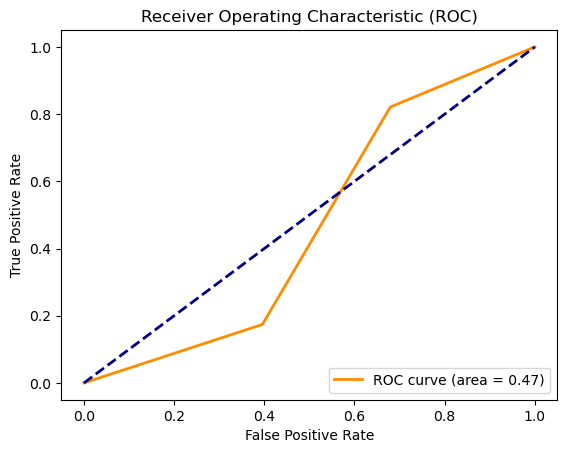

In [ ]:
val_accuracy, val_precision, val_recall, val_f1, y_true, y_pred = evaluate_model(best_model, val_loader)
print(f"Best Validation Metrics - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, "
      f"Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     27480 non-null  object
 1   text       27480 non-null  object
 2   sentiment  27480 non-null  object
dtypes: object(3)
memory usage: 858.8+ KB


In [98]:
df['text_length'] = df['text'].apply(lambda x: len(x))

In [99]:
df['text_words'] = df['text'].apply(lambda x: len(x.split()))

In [100]:
df.head()

,textID,text,sentiment,text_length,text_words
0,cb774db0d1,"I`d have responded, if I were going",neutral,36,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,46,10
2,088c60f138,my boss is bullying me...,negative,25,5
3,9642c003ef,what interview! leave me alone,negative,31,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,75,14


In [101]:
## Taking separate dataframes for different values such as positive, negative and neutral reviews respectively. 

positive_df = df[df['sentiment'] == 'positive']
negative_df = df[df['sentiment'] == 'negative']
neutral_df = df[df['sentiment'] == 'neutral']

In [102]:
wordcloud = WordCloud(width = 500, height = 500)

In [103]:
positive_df.head()

,textID,text,sentiment,text_length,text_words
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,positive,64,14
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,positive,69,10
11,16fab9f95b,I really really like the song Love Story by Ta...,positive,56,11
21,e48b0b8a23,Playing Ghost Online is really interesting. Th...,positive,135,24
25,e00c6ef376,"the free fillin` app on my ipod is fun, im add...",positive,51,11


In [104]:
positive_text = []
for i in range(len(positive_df)):
    positive_text.append(positive_df['text'].iloc[i])

In [105]:
positive_text[:5]

['2am feedings for the baby are fun when he is all smiles and coos',
 ' Journey!? Wow... u just became cooler.  hehe... (is that possible!?)',
 'I really really like the song Love Story by Taylor Swift',
 'Playing Ghost Online is really interesting. The new updates are Kirin pet and Metamorph for third job.  Can`t wait to have a dragon pet',
 'the free fillin` app on my ipod is fun, im addicted']

## 3. Positive Text WordCloud 

Worcloud gives us a good idea about the number of repeating words by the size of them. We see that there are some positive words such as "thank" and "good "which make up most of the positive reviews. There are also some words that occur quite rare such as "awesome" but these words also make a mark in the decisions respectively. In addition to this, we also find that there are very few words that are negative in the positive text. Therefore, we can conclude that words are a good indication of the polarity and sentiment of the text respectively. 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhij\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


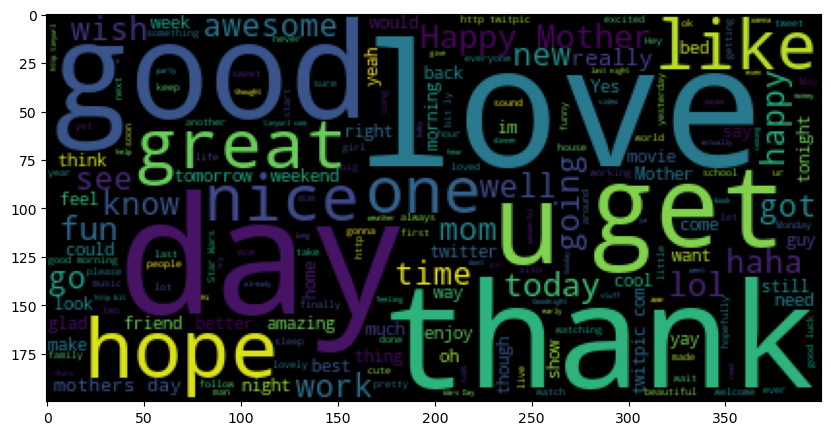

In [106]:
import nltk 
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
wordcloud = WordCloud(stopwords = stopwords)
wordcloud.generate(''.join(positive_text))
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud)
plt.show()

In [107]:
negative_text = []
for i in range(len(negative_df)):
    negative_text.append(negative_df['text'].iloc[i])

In [108]:
negative_text[0: 5]

[' Sooo SAD I will miss you here in San Diego!!!',
 'my boss is bullying me...',
 ' what interview! leave me alone',
 ' Sons of ****, why couldn`t they put them on the releases we already bought',
 'My Sharpie is running DANGERously low on ink']

## 4. Negative Text WordCloud 

As can be seen in the wordcloud, there are some words such as "miss" and "no" which are considered to be negative respectively. In addition to this, we see that there are some words such as "work" and "sorry" that also tend to be negative as this is quite true in real-life where we say "sorry" for some negative things done and so on. Therefore, getting the wordcloud would ensure that we get to know the words present in the wordcloud dictionary and ensure that we understand the full context of the review respectively. 

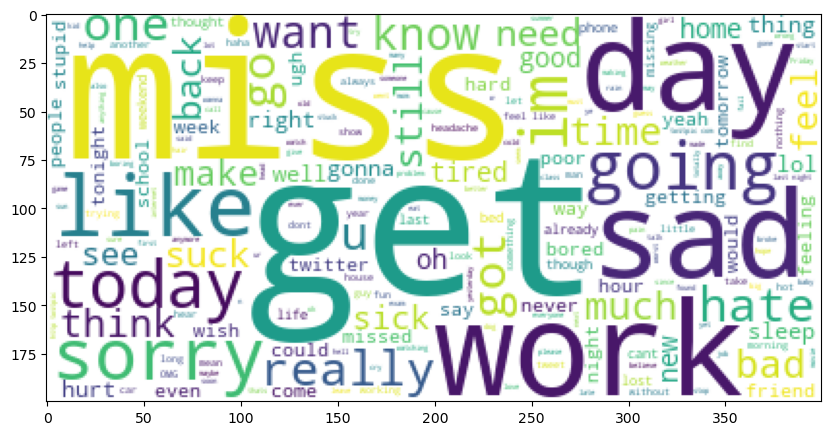

In [109]:
wordcloud = WordCloud(stopwords = stopwords, background_color = 'white')
wordcloud.generate(''.join(negative_text))
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud)
plt.show()

In [110]:
negative_df.head()

,textID,text,sentiment,text_length,text_words
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,46,10
2,088c60f138,my boss is bullying me...,negative,25,5
3,9642c003ef,what interview! leave me alone,negative,31,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,75,14
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,negative,44,8


## 5. List of Stopwords

Let us now make a list of all the stopwords that we are going to be using for our machine learning purposes. We see that there are some good list of stopwords that I have taken from the link that is provided in the below cell. These would be used for the stopwords and ensure that we are getting the best results respectively. 

In [111]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [112]:
df.drop(['textID'], axis = 1, inplace = True)

In [113]:
X = df.drop(['sentiment'], axis = 1)
y = df['sentiment']

## 6. Dividing the Data into Training and Cross Validation Data 

Now we are going to be dividing the data into training and cross validation data and ensure that we understand the machine learning model well. We are going to be dividing the data into 2 parts where 70 percent of the data is taken as the training data and the 30 percent of the data would be taken as the test data. There is a random state assigned to it and split to ensure that we get a good accuracy. 

In [114]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.3, random_state = 50)

In [115]:
X_train.shape

(19236, 3)

In [116]:
X_cv.shape

(8244, 3)

## 7. Function for Replacing Words

There is a separate function that is being used to replace the words and substitute them with the other words to ensure that we get the best machine learning results respectively. 

In [117]:

# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

## 8. Preprocessing the Text 

It is now time to preprocess the text and understand the output. We are going to be using the above functions and also estimate the time it takes to complete the entire preprocessing respectively. Taking into account the different preprocessing text values, we are going to be appending those values and understanding the output respectively. 

In [118]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_text = []
# tqdm is for printing the status bar
for sentence in tqdm(X_train['text'].values):
    sent = decontracted(sentence)
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_text.append(sent.lower().strip())

100%|██████████| 19236/19236 [00:00<00:00, 37079.52it/s]


In [119]:
preprocessed_text[0: 5]

['24 hours since dog put sleep rip old friend',
 'not feeling comfortable today',
 'hurray twin girls born beautiful may day',
 'bah h8 waking',
 'textmate crashed first time 3 months not bad actually textmate']

In [120]:
for i in range(len(X_train)):
    X_train['text'].iloc[i] = preprocessed_text[i]

In [121]:
X_train.head()

,text,text_length,text_words
19832,24 hours since dog put sleep rip old friend,78,18
10340,not feeling comfortable today,41,6
11044,hurray twin girls born beautiful may day,48,9
14088,bah h8 waking,19,5
20333,textmate crashed first time 3 months not bad a...,80,14


In [122]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_text = []
# tqdm is for printing the status bar
for sentence in tqdm(X_cv['text'].values):
    sent = decontracted(sentence)
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_text.append(sent.lower().strip())

100%|██████████| 8244/8244 [00:00<00:00, 36466.36it/s]


In [123]:
preprocessed_text[0: 5]

['mom happy present yayy',
 'no surprise probably know',
 'nope difference 5 omr c class anyone notice flight number wy flight lhr wy 911',
 'smells badly garlic',
 'friday whole different meaning work saturday sunday']

In [124]:
for i in range(len(X_cv)):
    X_cv['text'].iloc[i] = preprocessed_text[i]

In [125]:
X_cv.head()

,text,text_length,text_words
7214,mom happy present yayy,38,8
19840,no surprise probably know,67,11
19409,nope difference 5 omr c class anyone notice fl...,102,19
6600,smells badly garlic,25,5
7807,friday whole different meaning work saturday s...,78,14


In [126]:
binarizer = LabelBinarizer()
y_train_converted = binarizer.fit_transform(y_train)
binarizer = LabelBinarizer()
y_cv_converted = binarizer.fit_transform(y_cv)

In [127]:
y_cv_converted

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

## 9. Tfidf Vectorizer

With the help of Tfidf Vectorizer, it is easy to convert the text into the form of vector based on the word frequency and the inverse document frequency and get those values which could be fed to the machine learning models for prediction respectively. Having a look at those values, we are going to be taking them and predicting using the machine learning approach. 

In [128]:
vectorizer = TfidfVectorizer()
X_train_text = vectorizer.fit_transform(X_train['text'])
X_cv_text = vectorizer.transform(X_cv['text'])

In [129]:
X_train_text.shape

(19236, 20619)

In [130]:
X_train_text[0: 5]

<5x20619 sparse matrix of type '<class 'numpy.float64'>'
	with 31 stored elements in Compressed Sparse Row format>

In [131]:
to_categorical(np.arange(1, 10))

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [132]:
y_train

19832    negative
10340    negative
11044    positive
14088    negative
20333     neutral
           ...   
15650    positive
22638    positive
10124    positive
5601     positive
14001    negative
Name: sentiment, Length: 19236, dtype: object

We are now going to be converting the output values in a series format so that we can give these values to the neural network models that we would be working respectively. 

In [133]:
encoder = LabelEncoder()
y_train_converted = encoder.fit_transform(y_train)


In [134]:
y_train_converted

array([0, 0, 2, ..., 2, 2, 0])

In [135]:
y_train_final = to_categorical(y_train_converted)

In [136]:
X_train.head()

,text,text_length,text_words
19832,24 hours since dog put sleep rip old friend,78,18
10340,not feeling comfortable today,41,6
11044,hurray twin girls born beautiful may day,48,9
14088,bah h8 waking,19,5
20333,textmate crashed first time 3 months not bad a...,80,14


In [137]:
X_train_dropped = X_train.drop(['text'], axis = 1)

In [138]:
X_train.head()

,text,text_length,text_words
19832,24 hours since dog put sleep rip old friend,78,18
10340,not feeling comfortable today,41,6
11044,hurray twin girls born beautiful may day,48,9
14088,bah h8 waking,19,5
20333,textmate crashed first time 3 months not bad a...,80,14


In [139]:
X_train['text'].head()

19832          24 hours since dog put sleep rip old friend
10340                        not feeling comfortable today
11044             hurray twin girls born beautiful may day
14088                                        bah h8 waking
20333    textmate crashed first time 3 months not bad a...
Name: text, dtype: object

In [140]:
X_train_dropped = X_train.drop(['text'], axis = 1)

In [141]:
X_train_dropped.head()

,text_length,text_words
19832,78,18
10340,41,6
11044,48,9
14088,19,5
20333,80,14


In [142]:
X_cv.head()

,text,text_length,text_words
7214,mom happy present yayy,38,8
19840,no surprise probably know,67,11
19409,nope difference 5 omr c class anyone notice fl...,102,19
6600,smells badly garlic,25,5
7807,friday whole different meaning work saturday s...,78,14


In [143]:
X_cv_dropped = X_cv.drop(['text'], axis = 1)

In [144]:
X_cv_dropped.head()

,text_length,text_words
7214,38,8
19840,67,11
19409,102,19
6600,25,5
7807,78,14


We are going to be converting the values from 0 to 1 respectively. We would have to be converting those values so that it becomes easy to perform machine learning analysis and this ensures that there is no gradient shifting and having different range of weights when performing the machine learning analysis respectively.

In [145]:
scaler = MinMaxScaler()
X_train_final = scaler.fit_transform(X_train_dropped)
X_cv_final = scaler.transform(X_cv_dropped)

In [146]:
X_train_final[0: 5]

array([[0.54347826, 0.5483871 ],
       [0.27536232, 0.16129032],
       [0.32608696, 0.25806452],
       [0.11594203, 0.12903226],
       [0.55797101, 0.41935484]])

In [147]:
X_cv_final[0: 5]

array([[0.25362319, 0.22580645],
       [0.46376812, 0.32258065],
       [0.7173913 , 0.58064516],
       [0.15942029, 0.12903226],
       [0.54347826, 0.41935484]])

In [148]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

encoder = LabelEncoder()
y_cv_encoded = encoder.fit_transform(y_cv)

In [149]:
y_train_final = to_categorical(y_train_encoded)
y_cv_final = to_categorical(y_cv_encoded)

In [150]:
y_train_final[0: 5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [151]:
y_cv_final[0: 5]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [152]:
X_train_final[0: 5]

array([[0.54347826, 0.5483871 ],
       [0.27536232, 0.16129032],
       [0.32608696, 0.25806452],
       [0.11594203, 0.12903226],
       [0.55797101, 0.41935484]])

In [153]:
X_train.head()

,text,text_length,text_words
19832,24 hours since dog put sleep rip old friend,78,18
10340,not feeling comfortable today,41,6
11044,hurray twin girls born beautiful may day,48,9
14088,bah h8 waking,19,5
20333,textmate crashed first time 3 months not bad a...,80,14


## 11. Count Vectorizer

Now we are going to be using the bag of words to understand the text and get a good knowledge about it. Since the data that is given to the machine learning models need to be in the form of vectors, it would be good to convert the text values into different vectors so that it becomes easy for the machine learning models to perform the computations respectively.

In [154]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train['text'])
X_cv_vectorized = vectorizer.transform(X_cv['text'])

In [155]:
X_train_vectorized

<19236x20619 sparse matrix of type '<class 'numpy.int64'>'
	with 135844 stored elements in Compressed Sparse Row format>

In [156]:
X_train_final[0: 5]

array([[0.54347826, 0.5483871 ],
       [0.27536232, 0.16129032],
       [0.32608696, 0.25806452],
       [0.11594203, 0.12903226],
       [0.55797101, 0.41935484]])

Since the values that we have are not in the form of arrays and in the form of sparse matrices, it would be a good idea to convert the values into the form of arrays so that it becomes easy for the machine learning models to make the predictions and ensure that they are getting the best predictions. 

In [157]:
X_train_bow_toarray = X_train_vectorized.toarray()
X_cv_bow_toarray = X_cv_vectorized.toarray()

We have formed the arrays that we would be using and now it is time to understand the matrices and concatenate them so that we are going to perform the machine learning analysis respectively. We are now going to be using the deep neural networks and this would ensure that we are getting the best results respectively. 

In [158]:
X_train_new = np.concatenate((X_train_bow_toarray, X_train_final), axis = 1)
X_cv_new = np.concatenate((X_cv_bow_toarray, X_cv_final), axis = 1)

## 12. Neutral Network Model 

We would now be using the deep neural networks that we are going to be learning and ensure that we are getting the best predictions respectively. We would start with 100 neutrons from the first layer and followed by 25 neutrons in the second layer and 10 units in the third layer followed by 3 final layers which we are going to be using the softmax classifier for predictions respectively. 

In [159]:
model = Sequential()
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(25, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')



We would be running the deep neutral network model for 10 epochs to ensure that we are going to be getting the best results in the test set respectively. We are also going to give the cross validation data and see how our model would be performing with the cross validation data, taking into account different parameters such as accuracy and cross validation loss respectively. 

In [160]:
model.fit(X_train_new, y_train_final, epochs = 10, validation_data = (X_cv_new, y_cv_final))

Epoch 1/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4651 - loss: 1.0284 - val_accuracy: 0.6872 - val_loss: 0.7560
Epoch 2/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7057 - loss: 0.7072 - val_accuracy: 0.6993 - val_loss: 0.7254
Epoch 3/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8078 - loss: 0.5093 - val_accuracy: 0.6902 - val_loss: 0.7795
Epoch 4/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8672 - loss: 0.3686 - val_accuracy: 0.6863 - val_loss: 0.8765
Epoch 5/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9038 - loss: 0.2743 - val_accuracy: 0.6787 - val_loss: 0.9863
Epoch 6/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9249 - loss: 0.2149 - val_accuracy: 0.6733 - val_loss: 1.1866
Epoch 7/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9390 - loss: 0.1801 - val_accuracy: 0.6762 - val_loss: 1.2489
Epoch 8/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9456 - loss: 0.1508 - val_accuracy: 0.

## 13. Plots of the Results 

We would now be looking at the deep neural network plots and see how the values of accuracy and loss change with respect to the number of epochs that we are running. We see that as the number of epochs increase, there seems to be overfitting where the cross validation loss tends to go higher though there is a decrease in the training loss respectively. This gives us a clear indication that the model is overfitting after certain number of epochs are met. Therefore, we would be taking the right number of epochs when we are performing the machine learning analysis. 

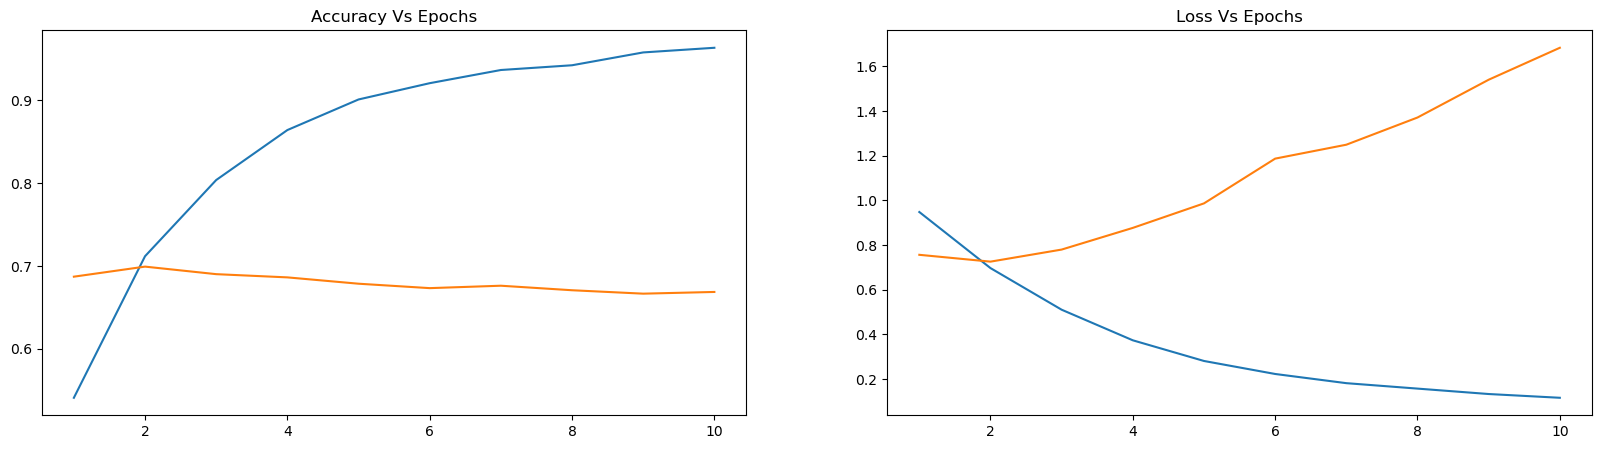

In [161]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = np.arange(1, 11)
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

sns.lineplot(x = epochs, y = accuracy, ax = ax[0])
sns.lineplot(x = epochs, y = val_accuracy, ax = ax[0])
ax[0].set_title('Accuracy Vs Epochs')
sns.lineplot(x = epochs, y = loss, ax = ax[1])
sns.lineplot(x = epochs, y = val_loss, ax = ax[1])
ax[1].set_title('Loss Vs Epochs')
plt.show()

## 14. Conclusions 

1. It would be a good idea to use some tools such as wordcloud when we are doing Natural Language Processing (NLP) to ensure that we are getting the best results for predictions respectively. We would be able to understand the frequently occurring words from the less frequently occurring words by the size of the words that are plotted in the wordcloud respectively. 
2. Steps should be taken to ensure that the model does not overfit or underfit. This ensures that the best predictions are being generated and therefore, we are going to get the best outputs respectively. 
3. Standarizing the text and ensuring that the values lie between 0 and 1 would be good as this would allow the machine learning models to generate weights that are quite small rather than having different weight range values. 